Loaded dataset with 2063 rows and columns: ['time', 'team', 'event', 'start_x', 'start_y', 'end_x', 'end_y', 'possession_duration', 'zone', 'dist_to_goal', 'possession_streak', 'pass_distance', 'team_encoded', 'event_encoded']
Accuracy: 0.2106537530266344
              precision    recall  f1-score   support

           0       0.04      0.33      0.08        15
           1       0.05      0.33      0.08         9
           2       0.65      0.18      0.29       240
           3       0.17      0.38      0.24        68
           4       0.60      0.11      0.19        81

    accuracy                           0.21       413
   macro avg       0.30      0.27      0.17       413
weighted avg       0.52      0.21      0.25       413

Baseline model saved at ../models/baseline_model.joblib


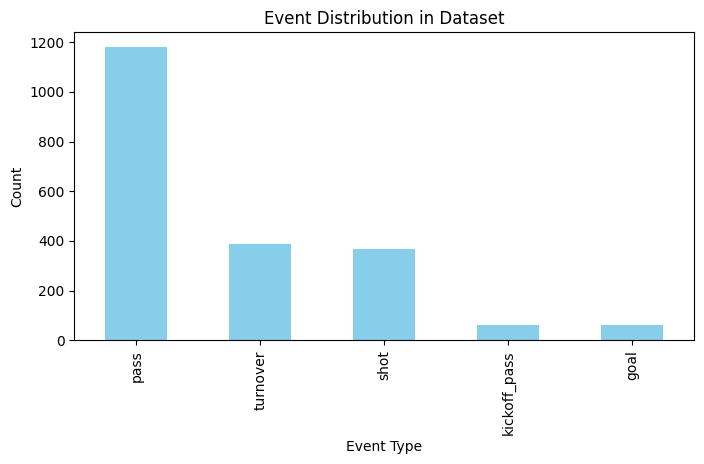

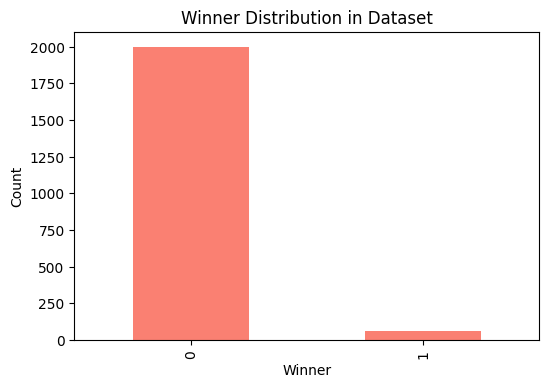

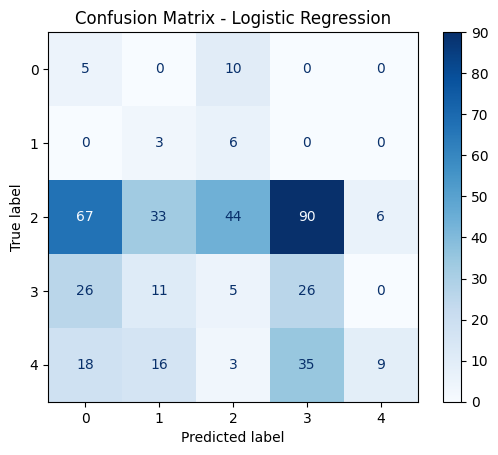

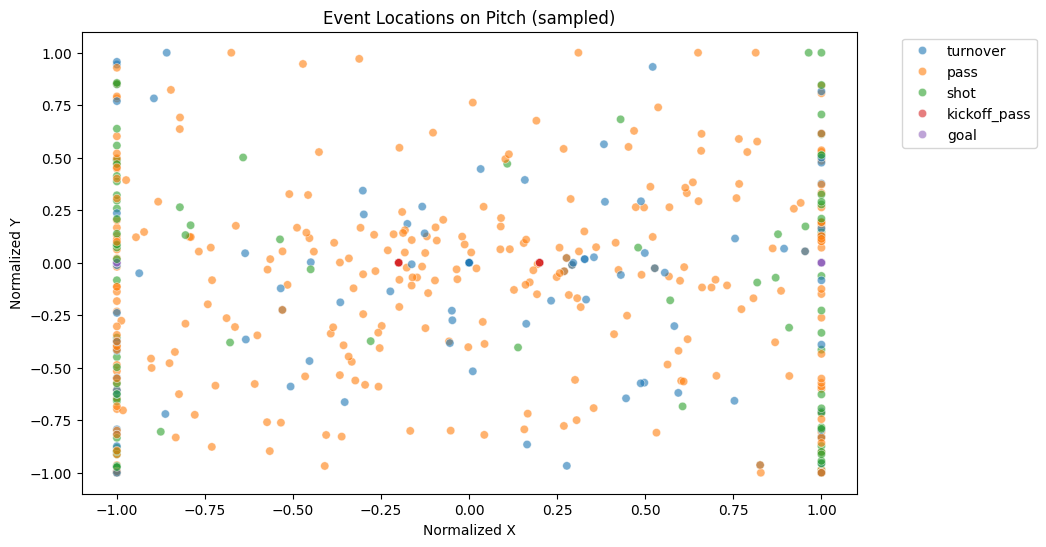

In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

CLEAN_FILE_PATH = "../data/processed/cleaned_data.csv"

MODEL_PATH = "../models/baseline_model.joblib"



def train_baseline():
    if not os.path.exists(CLEAN_FILE_PATH):
        raise FileNotFoundError(f"Cleaned data not found at {CLEAN_FILE_PATH}")

    df = pd.read_csv(CLEAN_FILE_PATH)
    print(f"Loaded dataset with {len(df)} rows and columns: {list(df.columns)}")

    # Ensure normalized coordinates exist
    if "x_norm" not in df.columns or "y_norm" not in df.columns:
        if "end_x" in df.columns and "end_y" in df.columns:
            df["x_norm"] = df["end_x"] / 50.0
            df["y_norm"] = df["end_y"] / 25.0
        else:
            raise ValueError("Neither normalized (x_norm, y_norm) nor raw (end_x, end_y) coordinates found.")

    # Encode team
    if "team_encoded" not in df.columns and "team" in df.columns:
        df["team_encoded"] = df["team"].astype("category").cat.codes

    # Encode events
    if "event_encoded" not in df.columns and "event" in df.columns:
        df["event_encoded"] = df["event"].astype("category").cat.codes

    # Encode winner (optional)
    if "winner" not in df.columns and "team" in df.columns:
        df["winner"] = (df["event"].str.lower() == "goal").astype(int)

    # Define features and target
    features = ["x_norm", "y_norm", "team_encoded"]
    target = "event_encoded"

    missing = [col for col in features + [target] if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    x = df[features]
    y = df[target]

    # Train/test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Train Logistic Regression model
    model = LogisticRegression(max_iter=1000, class_weight="balanced")
    model.fit(x_train, y_train)

    # Predictions & evaluation
    y_pred = model.predict(x_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Save model
    os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
    joblib.dump(model, MODEL_PATH)
    print(f"Baseline model saved at {MODEL_PATH}")

    # Display event distribution
    plt.figure(figsize=(8,4))
    df["event"].value_counts().plot(kind="bar", color="skyblue")
    plt.title("Event Distribution in Dataset")
    plt.xlabel("Event Type")
    plt.ylabel("Count")
    plt.show()

    # Display winner distribution
    if "winner" in df.columns:
        plt.figure(figsize=(6,4))
        df["winner"].value_counts().plot(kind="bar", color="salmon")
        plt.title("Winner Distribution in Dataset")
        plt.xlabel("Winner")
        plt.ylabel("Count")
        plt.show()

    # Confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, cmap="Blues")
    plt.title("Confusion Matrix - Logistic Regression")
    plt.show()

    # Optional: scatter plot of event locations on pitch
    plt.figure(figsize=(10,6))
    sample_df = df.sample(min(500, len(df)))  # sample to avoid overcrowding
    sns.scatterplot(data=sample_df, x="x_norm", y="y_norm", hue="event", alpha=0.6)
    plt.title("Event Locations on Pitch (sampled)")
    plt.xlabel("Normalized X")
    plt.ylabel("Normalized Y")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()


if __name__ == "__main__":
    try:
        train_baseline()
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print(f"Checked for file at: {CLEAN_FILE_PATH}")
        print("Please verify the file path and ensure the file exists and is accessible.")
